<br>
<font size="20">Customer Insights - Predictions - QC Acquisiton</font>

1. load data from BigQuery
3. definition of features
2. per use case: definition of target variables
4. predictions for acquisitions
5. export data to Google Storage bucket
6. data available through BigQuery view

[Confluence Documentation](https://confluence.deliveryhero.com/display/DINV/Customer+Segmentation)

# general

## libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing, linear_model, ensemble, metrics, model_selection
import lightgbm

import shap

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')
#from jupyterthemes import jtplot #;jtplot.style()

import datetime, dateutil
import os, sys, yaml, gc, psutil, argparse
from tqdm.auto import tqdm

from typing import Tuple, List

from IPython.display import display
from pprint import PrettyPrinter
pprint = PrettyPrinter(indent=1, width=160, compact=True).pprint

# main functions for this project
sys.path.insert(1, '../')
import functions as f

sys.path.insert(1, '../../')
from utils import utils
utils.set_pd_options()

pandas options updated


In [2]:
import watermark
print(watermark.watermark(
    python=True, hostname=True, machine=True,
    packages='pandas,numpy,pyarrow,lightgbm,shap,google.cloud.bigquery,google.cloud.bigquery_storage,google.cloud.storage'))

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

pandas                       : 1.2.4
numpy                        : 1.20.1
pyarrow                      : 6.0.1
lightgbm                     : 2.3.1
shap                         : 0.40.0
google.cloud.bigquery        : 2.31.0
google.cloud.bigquery_storage: 2.13.0
google.cloud.storage         : 1.43.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Hostname: C02FR0GZML86



## connections

In [3]:
from google.oauth2 import service_account
credentials = service_account.Credentials.from_service_account_file('/Users/temporaryadmin/cred/credentials.json')

from google.cloud import bigquery
bqclient = bigquery.Client(credentials=credentials, project=credentials.project_id)
print(f'connected to BigQuery, project: {bqclient.project}')

connected to BigQuery, project: quick-commerce-data


In [4]:
# from google.cloud import storage
# storage.blob._DEFAULT_CHUNKSIZE  = 5*1024*1024  # workaround for 60s timeout
# storage.blob._MAX_MULTIPART_SIZE = 5*1024*1024
# storage_client = storage.Client(credentials=credentials, project=credentials.project_id)
# bucket_gs = storage_client.get_bucket('darkstores-data-eng-us')
# print(f'connected to Google Storage, bucket: {bucket_gs.name}')

## parameters

In [5]:
IS_NOTEBOOK = utils.is_notebook()

if IS_NOTEBOOK:
    %load_ext autoreload
    %autoreload 2
    %config Completer.use_jedi = False
    shap.initjs() # initiate javascript notebook support for shap plots

today            = datetime.date.today()
this_week_monday = today + datetime.timedelta(days=-today.weekday(),   weeks=0)
last_week_sunday = today + datetime.timedelta(days=-today.weekday()-1, weeks=0)
today_string            = str(today)[:10]
this_week_monday_string = str(this_week_monday)
last_week_sunday_string = str(last_week_sunday)

print('today:               ', today_string)
print('this week monday:    ', this_week_monday)
print('last week sunday:    ', last_week_sunday)

today:                2022-04-14
this week monday:     2022-04-11
last week sunday:     2022-04-10


In [6]:
RUN_PERMUATION_IMP = False
N_CORES_ASSIGNED = psutil.cpu_count() - 2 # leave 2 cores free on local machine, increase to full capacity on server

# google storage directory
DIR_TOPIC = 'customer_insights/acquisition/'
DIR_PLOTS = DIR_TOPIC+'plots'

# local directory
DIR_TMP       = os.path.join(os.path.expanduser('~'), 'tmp')
DIR_TMP_PLOTS = os.path.join(DIR_TMP, 'plots')

os.makedirs(DIR_TMP,       exist_ok=True)
os.makedirs(DIR_TMP_PLOTS, exist_ok=True)

In [7]:
parser = argparse.ArgumentParser()
parser.add_argument("-geid", "--global_entity_id", type=str, default='OTHER')
if IS_NOTEBOOK: args = parser.parse_args("")
else:           args = parser.parse_args()

    
if args.global_entity_id=='OTHER':  GLOBAL_ENTITY_ID = 'OP_SE'# 'MJM_AT' #'
else:                               GLOBAL_ENTITY_ID = args.global_entity_id

GLOBAL_ENTITY_ID = GLOBAL_ENTITY_ID
DATE_UNTIL = last_week_sunday_string
#DATE_UNTIL = '2021-06-27'
print(f'\n\n{"-"*40}\n{GLOBAL_ENTITY_ID}, {DATE_UNTIL}\n{"-"*40}\n\n')

DATE_UNTIL_MINUS_7  = datetime.date.fromisoformat(DATE_UNTIL) - datetime.timedelta(days=7)
DATE_UNTIL_MINUS_28 = datetime.date.fromisoformat(DATE_UNTIL) - datetime.timedelta(days=28)

try:
    del df, export, x_train, x_valid, y_train, y_valid
    gc.collect()
except:
    pass



----------------------------------------
OP_SE, 2022-04-10
----------------------------------------




## functions
should be moved into separate file

In [8]:
def shap_summary_plot(shap_values, feature_df, top_n:int, target:str):
    "create shap summary plot, show and save to GS bucket"
    
    shap.summary_plot(shap_values,
                      feature_df, 
                      max_display=top_n, 
                      show=False)

    target_str = target.replace("target_", "")
    plt.title(f'{target_str}\n{GLOBAL_ENTITY_ID}, data until {DATE_UNTIL}, top {top_n} features')    
    
    plot_dir  = os.path.join(DIR_TMP_PLOTS, GLOBAL_ENTITY_ID, target)
    plot_path = os.path.join(DIR_TMP_PLOTS, GLOBAL_ENTITY_ID, target, f'shap_{GLOBAL_ENTITY_ID}_{DATE_UNTIL}_{target}.png')
    
    os.makedirs(plot_dir, exist_ok=True)
    plt.savefig(plot_path, format='png', dpi=120, bbox_inches='tight')
    utils.upload_gs_blob(bucket_gs, plot_path, 
                         f'{DIR_PLOTS}/entity={GLOBAL_ENTITY_ID}/date={DATE_UNTIL}/target={target}/',
                         verbose=False)

In [9]:
def shap_forces_single_row(shap_values_row, feature_names, color=True, top_n=None):
    shap_importance = (pd.DataFrame({'feature':feature_names,
                                     'shap_importance':shap_values_row})
                        .reset_index(drop=True)
                      )
    shap_importance['shap_importance_abs'] = shap_importance['shap_importance'].abs()
    shap_importance['shap_importance_rank'] = shap_importance['shap_importance_abs'].rank(method='average', ascending=False).astype(int)
    
    shap_importance = (shap_importance
                       .sort_values('shap_importance_rank', ascending=True)
                       .drop(columns='shap_importance_abs')
                       .reset_index(drop=True)
                      )

    if top_n is not None: shap_importance = shap_importance.head(top_n)
    if color: return shap_importance.style.background_gradient(subset='shap_importance', cmap='bwr', low=-0.4, high=0.4)
    else:     return shap_importance

# input

## load data

In [12]:
query = utils.sql_query_from_placeholders('sql/stage_data.sql',
                                          {'GLOBAL_ENTITY_ID':GLOBAL_ENTITY_ID, 'DATE_UNTIL':DATE_UNTIL})
# removed date_until from the sql query - now just takes calculations from yesterday's date
# print(query)

In [13]:
df = f.loaders.read_bigquery(query, bqclient, verbose=True)

running query... job done, downloading... 

Downloading:   0%|          | 0/1402117 [00:00<?, ?rows/s]

done with shape (1,402,117 x 108)


## dtype changes

In [14]:
date_cols = [c for c in df.columns if c.find('date')>=0]

for c in date_cols:
    try:    df[c] = pd.to_datetime(df[c])
    except: print('could not convert to dates:', c)

In [16]:
# # BQ transfers data as objects instead of int/float in many cases
# to_num_cols = df.drop(columns=['global_entity_id', 'analytical_customer_id']).select_dtypes('object').columns
# if len(to_num_cols)>0:
#     for c in tqdm(to_num_cols):
#         try:
#             df[c] = pd.to_numeric(df[c])
#         except Exception as e:
#             print(c.ljust(40), e)

In [107]:
#if IS_NOTEBOOK: 
(utils
 .df_info(df.iloc[:, -100:])
 .style.background_gradient(subset=['isnull_%'], cmap='Reds')
)

,column,dtype,memory_mb,nunique,notnull,isnull,isnull_%,min,max
0,first_order_delivery_fee_vert_rs,float64,11.210000,2281,1401209,0,0.000000,0.000000,59.500000
1,first_order_delivery_fee_pct_vert_rs,float64,11.210000,489699,1401209,0,0.000000,0.000000,568.000000
2,first_order_delivery_dist_m_vert_rs,float64,11.210000,8050,366851,1034358,73.820000,0.000000,8407830.000000
3,first_order_delivery_time_promised_vert_rs,float64,11.210000,3987,794588,606621,43.290000,-48.020000,308.000000
4,first_order_delivery_delay_vert_rs,float64,11.210000,5961,366851,1034358,73.820000,-976.120000,161.330000
5,first_order_discount_vert_rs,float64,11.210000,1639,1401209,0,0.000000,0.000000,83.350000
6,first_order_discount_pct_vert_rs,float64,11.210000,104515,1401209,0,0.000000,0.000000,236.500000
7,first_order_voucher_vert_rs,float64,11.210000,2267,1401209,0,0.000000,0.000000,324.310000
8,first_order_voucher_pct_vert_rs,float64,11.210000,58075,1401209,0,0.000000,0.000000,6486.200000
9,first_order_voucher_vert_qc,float64,11.210000,52,3813,1397396,99.730000,0.000000,48.970000


In [108]:
for c in df.columns: print(c, end=', ')

global_entity_id, analytical_customer_id, first_order_date_vert_rs, first_order_date_vert_qc, days_since_first_order_vert_rs, days_since_first_order_vert_qc, days_since_last_order_vert_rs, first_order_dayofweek_vert_rs, first_order_amt_gmv_eur_vert_rs, first_order_delivery_fee_vert_rs, first_order_delivery_fee_pct_vert_rs, first_order_delivery_dist_m_vert_rs, first_order_delivery_time_promised_vert_rs, first_order_delivery_delay_vert_rs, first_order_discount_vert_rs, first_order_discount_pct_vert_rs, first_order_voucher_vert_rs, first_order_voucher_pct_vert_rs, first_order_voucher_vert_qc, cust_lat, cust_long, order_perc_weekend_vert_rs, order_perc_morning_vert_rs, order_perc_afternoon_vert_rs, order_perc_night_vert_rs, order_count_lifetime_vert_rs, order_count_lifetime_vert_qc, order_count_lifetime_vert_dmart, order_count_l04w_vert_rs, order_count_l16w_vert_rs, order_count_late_lifetime_vert_rs, order_count_late_l04w_vert_rs, order_count_late_l16w_vert_rs, order_pct_late_l16w_vert_rs,

# features

## categorical

In [109]:
df.select_dtypes(['object', 'category']).columns

Index(['global_entity_id', 'analytical_customer_id'], dtype='object')

In [ ]:
# feat_catg = ['country']

In [ ]:
# df, cols_one_hot = f.features.create_one_hot_encoding(df, columns=['visit_last_platform_device'], 
#                                                       min_pctg_to_keep=0.005)
# print('\nfeatures one hot:', cols_one_hot)

## geo features

In [ ]:
# cust_lat, cust_long, last_order_h3_level_9

### lat lon only

### lat lon clusters kmeans

In [15]:
from sklearn.cluster import KMeans

In [16]:
df = df.loc[df[['cust_lat','cust_long']].dropna().index]

In [17]:
for size in [10, 20, 50, 100]:
    start = datetime.datetime.now()
    kmeans = KMeans(n_clusters=size)
    
    kmeans = kmeans.fit(df.loc[:, ['cust_lat', 'cust_long']].head(100_000))
    
    df[f'cluster_kmeans_{size}'] = kmeans.predict(df.loc[:, ['cust_lat', 'cust_long']])
    print(f'kmeans {size:>3}: {(datetime.datetime.now()-start).total_seconds():2.2f}s')

kmeans  10: 1.11s
kmeans  20: 1.71s
kmeans  50: 3.82s
kmeans 100: 9.71s


In [18]:
df['cust_lat'].head()

0    58.352830
1    59.863706
2    59.363955
3    59.393009
4    59.219476
Name: cust_lat, dtype: float64

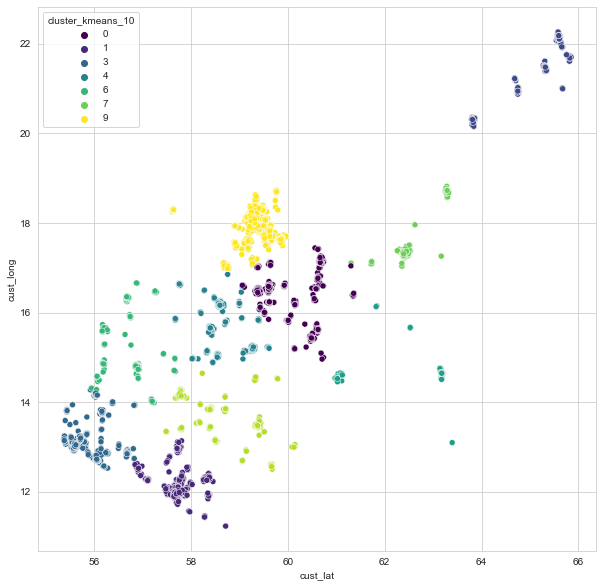

In [16]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df.loc[ :,:#(df['cust_lat']>20)
                            #&(df['cust_long']>53)
                           ].sample(10_000), x='cust_lat', y='cust_long', hue='cluster_kmeans_10', palette='viridis');

In [127]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df.loc[ (df['cust_lat']>20)
                            &(df['cust_long']>53)
                           ].sample(10_000), x='cust_lat', y='cust_long', hue='cluster_kmeans_20', palette='viridis');

ValueError: a must be greater than 0 unless no samples are taken

<Figure size 720x720 with 0 Axes>

In [19]:
features_kmeans = f.features.get_features_list(df, contains=['kmeans'])

found columns: 4


### clusters hdbscan

In [129]:
import hdbscan

ModuleNotFoundError: No module named 'hdbscan'

In [ ]:
%%time
for cluster_size in [200, 500, 1000, 5000, 10000]:
    start = datetime.datetime.now()
    clusterer = hdbscan.HDBSCAN(min_cluster_size=cluster_size, min_samples=50, core_dist_n_jobs=-1)
    df[f'cluster_hdbscan_min{cluster_size}'] = clusterer.fit_predict(df.loc[:, ['cust_lat', 'cust_long']].values)
    df[f'cluster_hdbscan_min{cluster_size}_outlier_score'] = clusterer.outlier_scores_
    print(f'size: {cluster_size}\t clusters:', df[f'cluster_hdbscan_min{cluster_size}'].nunique(), f'\t time: {(datetime.datetime.now()-start).total_seconds():2.2f}s')

In [ ]:
features_hdbscan = f.features.get_features_list(df, contains=['hdbscan'])

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df.loc[ (df['cust_lat']>20)
                            &(df['cust_long']>53)
                           ].sample(1_000), x='cust_lat', y='cust_long', hue='cluster_hdbscan_min10000', palette='viridis');

### kdtree density

In [20]:
from sklearn.neighbors import KDTree

In [21]:
%%time
kdt = KDTree(data=df.loc[:, ['cust_lat', 'cust_long']].values[:100_000])

CPU times: user 47.7 ms, sys: 2.45 ms, total: 50.1 ms
Wall time: 51.5 ms


In [22]:
%%time
in_radius_001 = kdt.query_radius(X=df.loc[:, ['cust_lat', 'cust_long']].values, r=0.01)
in_radius_001 = [len(a) for a in in_radius_001]
df['density_count_radius_0.01'] = in_radius_001

CPU times: user 12 s, sys: 1 s, total: 13 s
Wall time: 13.2 s


In [23]:
%%time
in_radius_003 = kdt.query_radius(X=df.loc[:, ['cust_lat', 'cust_long']].values, r=0.03)
in_radius_003 = [len(a) for a in in_radius_003]
df['density_count_radius_0.03'] = in_radius_003

CPU times: user 23.3 s, sys: 3.76 s, total: 27 s
Wall time: 27.4 s


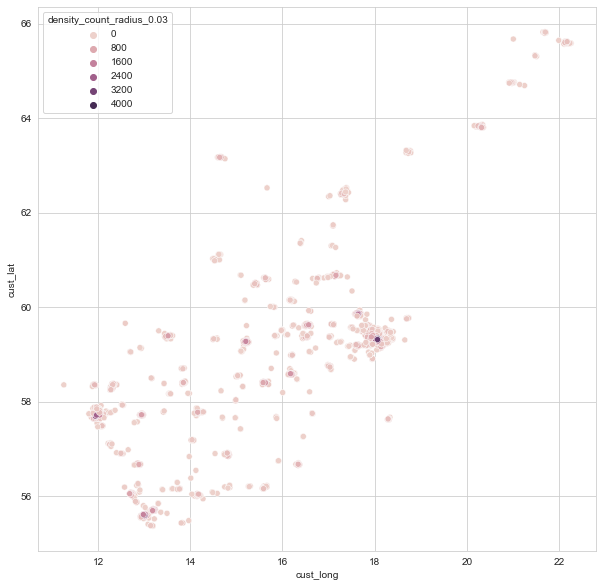

In [24]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df.sample(3_000), 
                x='cust_long', y='cust_lat',
                hue='density_count_radius_0.03', #palette='viridis'
               );

In [26]:
features_density = ['density_count_radius_0.01', 'density_count_radius_0.03']

### h3 hexagons

In [138]:
df['last_order_h3_level_8'].head()

KeyError: 'last_order_h3_level_8'

In [ ]:
query = """
    SELECT
        h38_id,
        CAST(population AS INT64) AS h38_population
    FROM `dh-global-sales-data.geolayer.worldpop_h38`
    WHERE country_iso IN ('SG', 'AE')
"""

In [ ]:
pop = pd.read_csv('h3_population.csv')
pop.shape

In [ ]:
df = pd.merge(df, pop, how='left', left_on='last_order_h3_level_8', right_on='h38_id')

In [ ]:
features_h3 = ['h38_population']

### final

In [27]:
features_geo = [
#     'cust_lat', 'cust_long'
     *features_kmeans
#     ,*features_hdbscan
    ,*features_density
#     ,*features_h3
#     ,'dist_nearest_vendor_qc', 'dist_nearest_dmart', 'dist_nearest_localstore'
#     ,'coverage_vendors_qc', 'coverage_dmart', 'coverage_localstore'
#     ,'coverage_convenience', 'coverage_groceries', 'coverage_supermarket'
#     ,'coverage_vendors_qc_in_2000m', 'coverage_vendors_qc_in_4000m', 'coverage_vendors_qc_in_6000m'
]

In [25]:
utils.display_df(df.loc[:, features_geo].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).T#.astype(int)
                )

,count,mean,std,min,10%,25%,50%,75%,90%,99%,max
cluster_kmeans_10,1330431.0,5.056201,3.500385,0.0,1.0,1.0,4.0,9.0,9.0,9.0,9.0
cluster_kmeans_100,1330431.0,35.590953,27.674652,0.0,2.0,12.0,33.0,52.0,79.0,92.0,99.0
cluster_kmeans_20,1330431.0,10.313023,6.861643,0.0,2.0,4.0,9.0,19.0,19.0,19.0,19.0
cluster_kmeans_50,1330431.0,23.744616,16.259132,0.0,3.0,12.0,21.0,36.0,49.0,49.0,49.0
density_count_radius_0.01,1330431.0,164.182302,170.306980,0.0,16.0,45.0,106.0,220.0,402.0,750.0,973.0
density_count_radius_0.03,1330431.0,915.413254,940.437751,0.0,86.0,245.0,558.0,1233.0,2457.0,3963.0,4542.0


In [ ]:
#df['cluster_hdbscan_min5000_outlier_score'].hist(bins=50);

## continuous

In [23]:
# unique prefixes
if IS_NOTEBOOK:
    print(sorted(list(set([col.split('past')[0].split('nv_')[0].split('rs_')[0] 
                           for col in df.columns]))))

['analytical_customer_id', 'aos_rating_last', 'aos_score_last', 'ccc_sessions_l04w', 'coverage_convenience', 'coverage_dmart', 'coverage_groceries', 'coverage_localstore', 'coverage_supermarket', 'coverage_vendo', 'cust_lat', 'cust_long', 'days_since_first_order_vert_qc', 'days_since_first_order_vert_rs', 'days_since_last_order_vert_rs', 'deliv_dist_m_avg_l04w_vert_ls', 'deliv_dist_m_avg_l04w_vert_rs', 'deliv_dist_m_avg_l16w_vert_ls', 'deliv_dist_m_avg_l16w_vert_rs', 'deliv_dist_m_avg_lifetime_vert_ls', 'deliv_dist_m_avg_lifetime_vert_rs', 'deliv_time_promised_avg_l04w_vert_rs', 'deliv_time_promised_avg_l16w_vert_rs', 'deliv_time_promised_avg_lifetime_vert_rs', 'delivery_delay_avg_l04w_vert_rs', 'delivery_delay_avg_l16w_vert_rs', 'delivery_delay_avg_lifetime_vert_rs', 'delivery_fee_avg_l04w_vert_rs', 'delivery_fee_avg_l16w_vert_rs', 'delivery_fee_avg_lifetime_vert_rs', 'delivery_fee_sum_l04w_vert_rs', 'delivery_fee_sum_l16w_vert_rs', 'delivery_fee_sum_lifetime_vert_rs', 'discount_avg_l

In [ ]:
# if IS_NOTEBOOK:
#     df['orders_of_visits_l12w'] = (df['order_count_l12w_vert_rs'] / df['visit_count_l12w']).clip(-1, 2)
#     df['orders_of_visits_l12w'].hist(bins=25);

In [28]:
features_qubik = [
    ### cause overfit for some reason
    #'customer_id_countd', 'visit_vendors_viewed_l04w', 'visit_vendors_available_l04w', 'visit_addresses_unique_l04w', 'visit_count_l04w',
    'order_rate_online_payment_l04w',
    'visit_count_l12w', 'visit_count_l04w_vs_l12w',
    'visit_session_dur_sum_l04w', 'visit_session_dur_avg_l04w',
    'visit_interact_speed_avg_l04w', 'visit_cart_abandon_rate_l04w', 'visit_search_fail_rate_l04w', 'visit_voucher_error_rate_l04w',
    'rating_avg_l04w', 
    'aos_score_last', 'aos_rating_last',
    'ccc_sessions_l04w',
    #'visit_channel_first', 'visit_channel_last', 'visit_last_platform_device', 
]

In [30]:
utils.display_df(df.loc[:, features_qubik].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).T)

,count,mean,std,min,10%,25%,50%,75%,90%,99%,max
order_rate_online_payment_l04w,529010.0,0.999358,0.025316,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
visit_count_l12w,1195470.0,8.406215,12.744822,0.0,0.000000,1.000000,4.000000,10.000000,21.000000,59.000000,740.0
visit_count_l04w_vs_l12w,999947.0,0.262140,0.284140,0.0,0.000000,0.000000,0.200000,0.400000,0.666667,1.000000,1.0
visit_session_dur_sum_l04w,633950.0,29282.861287,67393.001729,1.0,460.000000,2430.000000,9482.000000,28940.000000,72499.100000,291784.000000,12608499.0
visit_session_dur_avg_l04w,1195470.0,15528.511726,51206.239362,0.0,0.000000,0.000000,196.000000,10753.000000,40008.100000,213821.240000,12608499.0
visit_interact_speed_avg_l04w,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visit_cart_abandon_rate_l04w,640634.0,0.132426,0.246981,0.0,0.000000,0.000000,0.000000,0.200000,0.500000,1.000000,1.0
visit_search_fail_rate_l04w,640634.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
visit_voucher_error_rate_l04w,496834.0,0.008725,0.069742,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,1.0
rating_avg_l04w,528164.0,0.848328,0.057065,0.2,0.775907,0.819199,0.855975,0.886399,0.911100,0.949477,1.0


In [31]:
utils.df_info(df.loc[:, features_qubik]).style.background_gradient()

,column,dtype,memory_mb,nunique,notnull,isnull,isnull_%,min,max
0,order_rate_online_payment_l04w,float64,9.560000,3,529010,666460,55.750000,0.000000,1.000000
1,visit_count_l12w,int64,9.560000,316,1195470,0,0.000000,0.000000,740.000000
2,visit_count_l04w_vs_l12w,float64,9.560000,2774,999947,195523,16.360000,0.000000,1.000000
3,visit_session_dur_sum_l04w,float64,9.560000,115561,633950,561520,46.970000,1.000000,12608499.000000
4,visit_session_dur_avg_l04w,int64,9.560000,115562,1195470,0,0.000000,0.000000,12608499.000000
5,visit_interact_speed_avg_l04w,float64,9.560000,0,0,1195470,100.000000,nan,nan
6,visit_cart_abandon_rate_l04w,float64,9.560000,670,640634,554836,46.410000,0.000000,1.000000
7,visit_search_fail_rate_l04w,float64,9.560000,1,640634,554836,46.410000,0.000000,0.000000
8,visit_voucher_error_rate_l04w,float64,9.560000,161,496834,698636,58.440000,0.000000,1.000000
9,rating_avg_l04w,float64,9.560000,311228,528164,667306,55.820000,0.200000,1.000000


In [29]:
features_cont = f.features.get_features_list(df, 'number', contains=['vert_rs'])
features_ls = f.features.get_features_list(df, 'number', contains=['vert_ls'])
#features_cont

found columns: 64
found columns: 4


## final features

In [30]:
feat_one_hot = f.features.get_features_list(df, contains=['one_hot'])

found columns: 0


In [31]:
features_ls

['deliv_dist_m_avg_l04w_vert_ls',
 'deliv_dist_m_avg_l16w_vert_ls',
 'deliv_dist_m_avg_lifetime_vert_ls',
 'dist_nearest_localstore_vert_ls']

In [32]:
# exclude one-hot for now
features_all = (
    features_cont
    + feat_one_hot
    +features_geo
    + features_qubik
    + features_ls
)
len(features_all)

87

## check

In [ ]:
# df.loc[:, ['dist_nearest_dmart', 'dist_nearest_localstore', 'dist_nearest_vendor_qc']].describe().astype(int)

# predictions

- generate predictions with a single model
- get regular and permutation feature importances
- remove useless features
- train out-of-fold models with reduced feature set

In [ ]:
# list(df.columns)

## general acquisition

In [ ]:
features_cont

In [219]:
# df = backup.copy()

In [35]:
# acquired, if at least one QC order
print('='*12, 'general trial probability', '='*12)
df, target = f.targets.create_acquisition_general(df)
utils.display_value_counts(df[target])

============ general trial probability ============


,target_acquisition_qc_general_0_1,count,%
0,0,92375,88.49
1,1,12014,11.51


In [ ]:
# backup = df.copy()

In [34]:
df = pd.concat([
    df[df[target]==0].sample(frac = 0.07,random_state = 2),
    df[df[target]==1]
])

In [31]:
# # check for differences between target groups, check to avoid overfitting, target leakage, etc
# (df
#  .groupby(target)
#  .agg({'days_since_first_order_vert_rs':['mean', 'min', 'max'],
#        'days_since_last_order_vert_rs':['mean', 'min', 'max'],
#        'voucher_dh_sum_vert_rs_lifetime':['mean', 'min', 'max'],
#        'order_amount_gmv_eur_avg_vert_rs_lifetime':['mean', 'min', 'max'],
#        'delivery_fee_sum_vert_rs_lifetime':['mean', 'min', 'max'],
#        'discount_other_sum_vert_rs_lifetime':['mean', 'min', 'max']
#       })
#  .reset_index()
#  .T
# )

### benchmark model

In [36]:
# generate simplest possible 'predictions' as a baseline
df['preds_acquisition_qc_general_benchmark'] = df[target].mean()

print('Benchmark model:', f.metrics.binary_metrics_text(df[target], df['preds_acquisition_qc_general_benchmark']))

Benchmark model: roc auc: 0.5000 | f1: 0.0000 | precision: 0.0000 | recall: 0.0000 | accuracy: 0.8849 | log loss: 0.3570 | 2022-04-14 13:25:33


### single train/valid model

In [37]:
# split with simple 80-20 method
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    df.loc[:, features_all],
    df.loc[:, target],
    stratify=df.loc[:, target],
    test_size=0.2, random_state=42)

print(f'x train: {utils.df_shape(x_train).rjust(17)} | y_train:', f'{len(y_train):>9,} | mean {y_train.mean():,.6f}')
print(f'x valid: {utils.df_shape(x_valid).rjust(17)} | y_valid:', f'{len(y_valid):>9,} | mean {y_valid.mean():,.6f}')

x train:     (83,511 x 87) | y_train:    83,511 | mean 0.115087
x valid:     (20,878 x 87) | y_valid:    20,878 | mean 0.115097


In [38]:
# basic parameters, not too deep, some regularization with min_child_samples and 80% feature use
params_init = {
    'objective':'binary',  'learning_rate': 0.08, 'n_estimators': 2000, 'min_split_gain': 0.003,
    'num_leaves': 2**7-1, 'max_depth': 7, 'min_child_samples': 200, 'colsample_bytree': 0.8, 
    'reg_alpha': 0.5, 'reg_lambda': 0.5,
    'n_jobs': N_CORES_ASSIGNED, 'random_state': 42, 
    'verbose': -1, #'force_col_wise':True
}
model_lgb = lightgbm.LGBMClassifier(**params_init)

model_lgb.fit(X=x_train, y=y_train,
              eval_set=(x_valid, y_valid),
              early_stopping_rounds=20, verbose=100);

y_pred = model_lgb.predict_proba(x_valid)[:,1]

print()
print('LightGBM model: ', f.metrics.binary_metrics_text(y_valid, y_pred))
print('Benchmark model:', f.metrics.binary_metrics_text(df[target], df['preds_acquisition_qc_general_benchmark']))

Training until validation scores don't improve for 20 rounds
[100]	valid_0's binary_logloss: 0.206154
[200]	valid_0's binary_logloss: 0.201945
Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.201472

LightGBM model:  roc auc: 0.9250 | f1: 0.5419 | precision: 0.7100 | recall: 0.4382 | accuracy: 0.9147 | log loss: 0.2015 | 2022-04-14 13:25:38
Benchmark model: roc auc: 0.5000 | f1: 0.0000 | precision: 0.0000 | recall: 0.0000 | accuracy: 0.8849 | log loss: 0.3570 | 2022-04-14 13:25:38


In [39]:
cluster_mapping_df = df.loc[y_valid.index][['cust_lat','cust_long']].join(
    x_valid.loc[y_valid.index][features_geo]).join(
    y_valid)
cluster_mapping_df['prediction'] = y_pred

In [40]:
cluster_metrics = dict()
for label in cluster_mapping_df[features_geo[0]].unique():

    row = cluster_mapping_df[cluster_mapping_df[features_geo[0]]==label]
    try:
        metric_string = f.metrics.binary_metrics_text(row['target_acquisition_qc_general_0_1'],row['prediction'])
        recall_index = metric_string.find('recall')
        cluster_metrics[label] = float(metric_string[recall_index:].split(':')[1].split('|')[0].strip(' '))
    except:
        cluster_metrics[label] = np.nan

In [41]:
cluster_accuracy = cluster_mapping_df[['cust_lat','cust_long',features_geo[0]]].groupby(features_geo[0])[['cust_lat','cust_long']].mean().join(pd.DataFrame(cluster_metrics,index=[features_geo[0]]).T).join(cluster_mapping_df.groupby('cluster_kmeans_10')['prediction'].mean())
cluster_accuracy

,cust_lat,cust_long,cluster_kmeans_10,prediction
cluster_kmeans_10,,,,
0,55.816263,13.070567,0.3074,0.102557
1,59.358807,17.953252,0.5104,0.145823
2,64.679034,21.070738,0.4747,0.156735
3,57.095337,14.832893,0.4074,0.062585
4,60.067766,16.467559,0.2105,0.033534
5,58.723527,15.629458,0.3603,0.142584
6,57.728110,12.112949,0.4178,0.124401
7,58.983902,13.600358,NaN,0.000507
8,62.648149,14.700271,NaN,0.000523


Text(0.5, 1.0, 'Conversion Likelihood Accuracy')

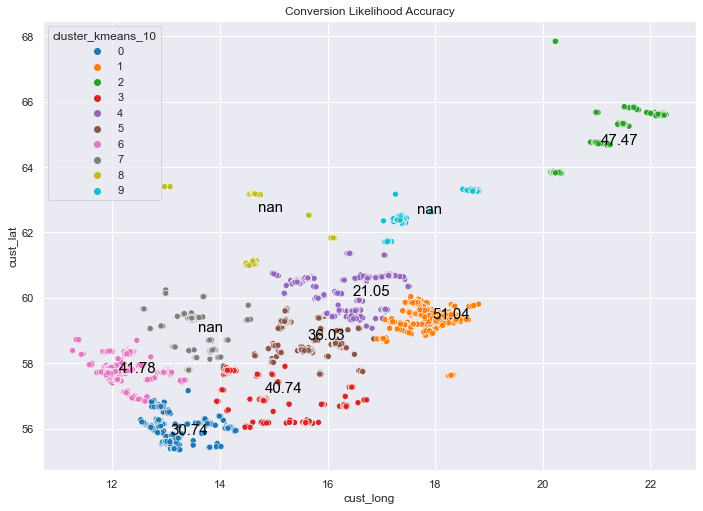

In [45]:
fig,ax = plt.subplots(1,1)
sns.set(rc={'figure.figsize':(21.7,21.27)})

sns.scatterplot(
    data = cluster_mapping_df,
    y = 'cust_lat',
    x = 'cust_long',
    hue = features_geo[0],
    ax=ax,
    palette = 'tab10'
)


for _,row in cluster_accuracy.iterrows():
    ax.annotate(
        f'{np.round(row[features_geo[0]]*100,2)}', 
        (row['cust_long'], row['cust_lat']),size=15,color='black'
    )
plt.title("Conversion Likelihood Accuracy")

Text(0.5, 1.0, 'Conversion Likelihood by region')

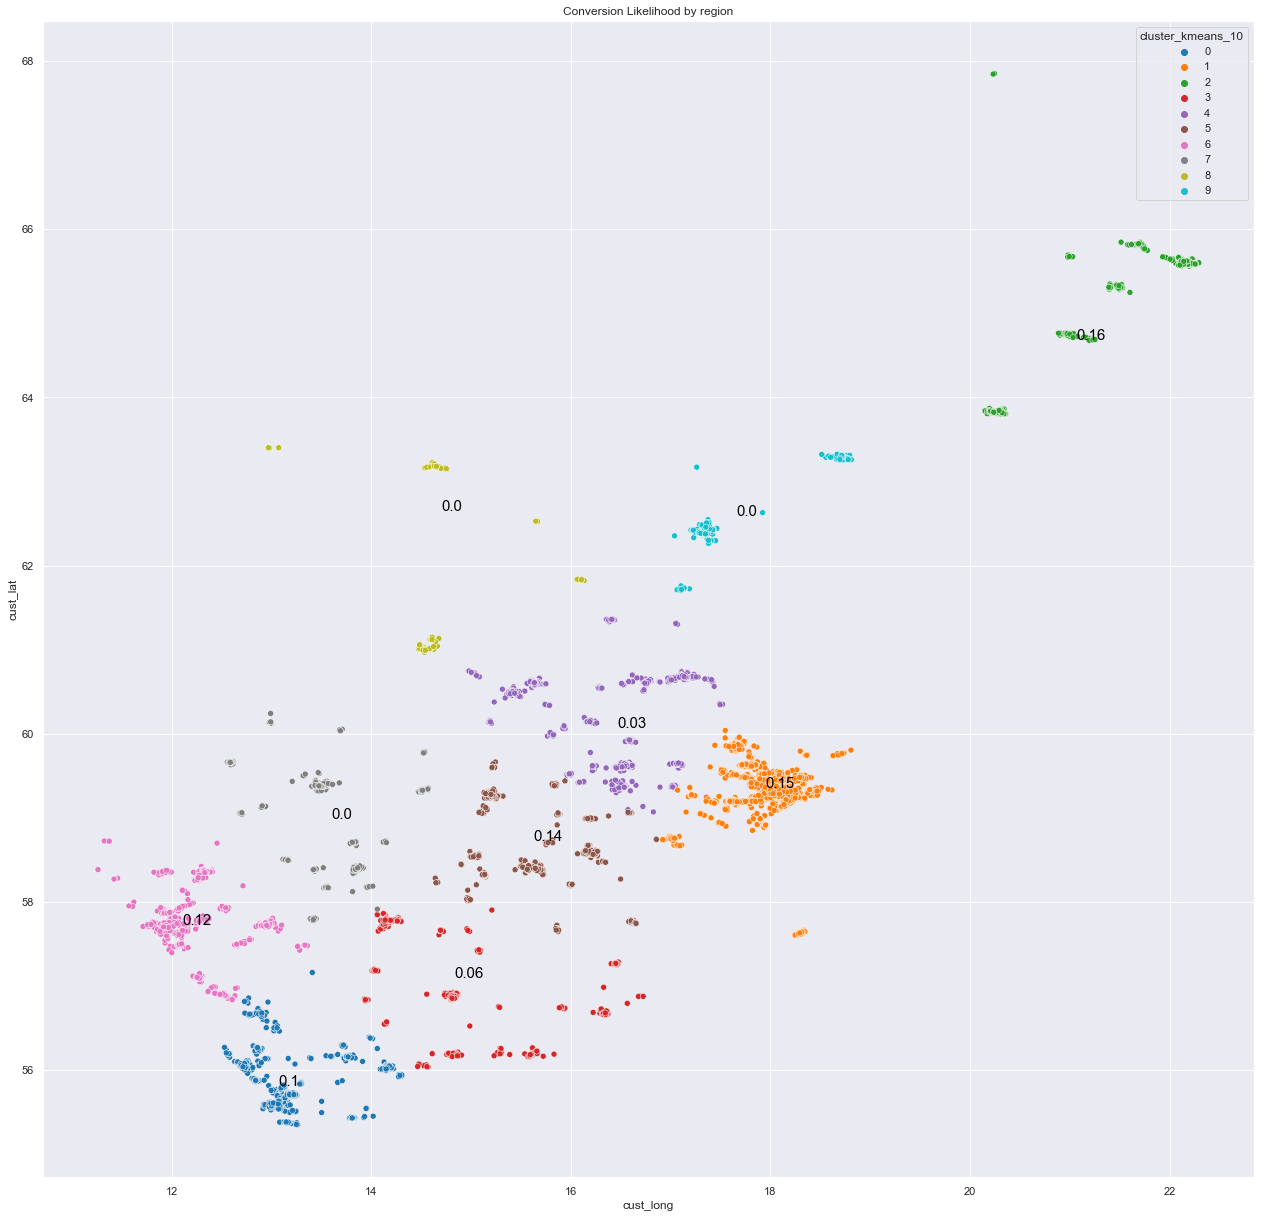

In [46]:
fig,ax = plt.subplots(1,1)
sns.set(rc={'figure.figsize':(21.7,21.27)})

sns.scatterplot(
    data = cluster_mapping_df,
    y = 'cust_lat',
    x = 'cust_long',
    hue = features_geo[0],
    ax=ax,
    palette = 'tab10'
)


for _,row in cluster_accuracy.iterrows():

    ax.annotate(
        np.round(row['prediction'],2), 
        (row['cust_long'], row['cust_lat']),size=15,color='black'
    )
plt.title('Conversion Likelihood by region')

In [50]:
#running the simulation largely

sample_frac = []
model_metrics_sweden = {}
# imbalance_effect = {}
frac = 0.07
# for frac in np.arange(0.01,0.11,0.01):
for i in range(30):
    df = backup.copy()

    df, target = f.targets.create_acquisition_general(df)
    df = pd.concat([
        df[df[target]==0].sample(frac = frac,random_state = i),
        df[df[target]==1]
    ])

    x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
        df.loc[:, features_all],
        df.loc[:, target],
        stratify=df.loc[:, target],
        test_size=0.2, random_state=42)



    # basic parameters, not too deep, some regularization with min_child_samples and 80% feature use
    params_init = {
        'objective':'binary',  'learning_rate': 0.08, 'n_estimators': 2000, 'min_split_gain': 0.003,
        'num_leaves': 2**7-1, 'max_depth': 7, 'min_child_samples': 200, 'colsample_bytree': 0.8, 
        'reg_alpha': 0.5, 'reg_lambda': 0.5,
        'n_jobs': N_CORES_ASSIGNED, 'random_state': 42, 
        'verbose': -1, #'force_col_wise':True
    }
    model_lgb = lightgbm.LGBMClassifier(**params_init)

    model_lgb.fit(X=x_train, y=y_train,
                  eval_set=(x_valid, y_valid),
                  early_stopping_rounds=20, verbose=100);

    y_pred = model_lgb.predict_proba(x_valid)[:,1]

    metric_string = f.metrics.binary_metrics_text(y_valid, y_pred)
    recall_index = metric_string.find('recall')
    model_metrics_sweden[i] = float(metric_string[recall_index:].split(':')[1].split('|')[0].strip(' '))
#     imbalance_effect[frac] = np.mean(list(model_metrics.values()))

Training until validation scores don't improve for 20 rounds
[100]	valid_0's binary_logloss: 0.202206
[200]	valid_0's binary_logloss: 0.19888
Early stopping, best iteration is:
[224]	valid_0's binary_logloss: 0.198475
Training until validation scores don't improve for 20 rounds
[100]	valid_0's binary_logloss: 0.200738
[200]	valid_0's binary_logloss: 0.197353
Early stopping, best iteration is:
[251]	valid_0's binary_logloss: 0.196899
Training until validation scores don't improve for 20 rounds
[100]	valid_0's binary_logloss: 0.199776
[200]	valid_0's binary_logloss: 0.196687
Early stopping, best iteration is:
[272]	valid_0's binary_logloss: 0.196225
Training until validation scores don't improve for 20 rounds
[100]	valid_0's binary_logloss: 0.201894
[200]	valid_0's binary_logloss: 0.19842
Early stopping, best iteration is:
[248]	valid_0's binary_logloss: 0.198118
Training until validation scores don't improve for 20 rounds
[100]	valid_0's binary_logloss: 0.200172
[200]	valid_0's binary_l

In [51]:
def plot_accuracy_dist(params,ax):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    
    for metric,country,color in zip(params['metrics'],params['countries'],params['color_map']):
        sns.kdeplot(metric.values(),fill=True,gridsize=50,ax=ax,color=color,alpha =0.1)
        mean_accuracy = np.mean(list(metric.values()))
        ax.axvline(mean_accuracy,ls='--',label = f'mean_{country} {round(mean_accuracy*100,2)} %' ,color=color,alpha=0.5)
        ci_interval = get_ci_interval(metric)
        ax.fill_between(ci_interval,[31,31],color=color,alpha=0.2)
        
    return ax

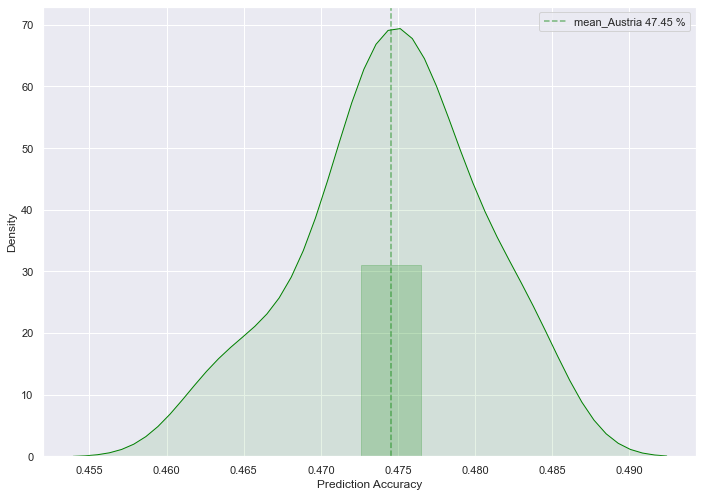

In [52]:
fig,ax = plt.subplots(1,1)
params = {
    'metrics':[model_metrics_sweden],
    'countries':['Austria'],
    'color_map':['green']
}
ax = plot_accuracy_dist(params,ax)
ax.set_xlabel('Prediction Accuracy')
plt.legend()

In [53]:
get_ci_interval(model_metrics_sweden)

[0.4725817568458729, 0.47651157648746045]

<bound method Axes.plot of <AxesSubplot:xlabel='Prediction Accuracy', ylabel='Density'>>

In [206]:
labels = ['52:48','68:32','76:24','82:18','84:16','86:14','88:12','90:10','92:08','94:06']

Text(0, 0.5, 'Accuracy Improvement$\\rightarrow$')

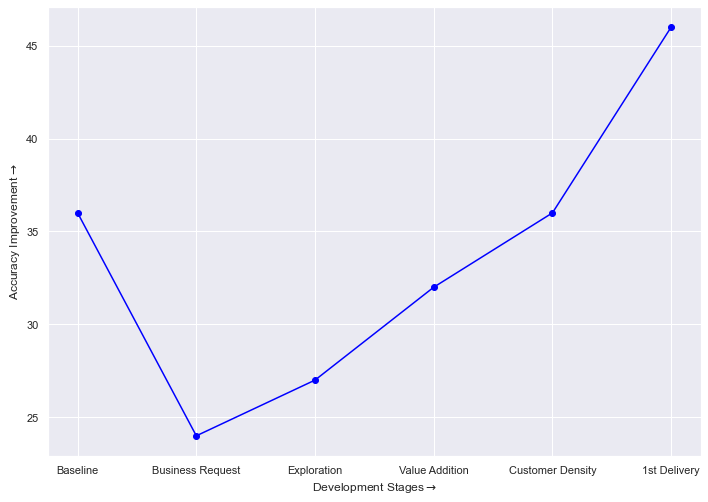

In [60]:
xdata = [1,2,3,4,5,6]
ydata = [36,24,27,32,36,46]
labels = ['Baseline','Business Request','Exploration','Value Addition','Customer Density','1st Delivery']
plt.plot(xdata,ydata,marker='o',color='blue');
plt.xticks(xdata, labels, rotation='horizontal');
plt.xlabel(f"Development Stages"+ r"$\rightarrow$")
plt.ylabel(f"Accuracy Improvement"+ r"$\rightarrow$")

Text(0.082, 0.45, 'We are here at 46%')

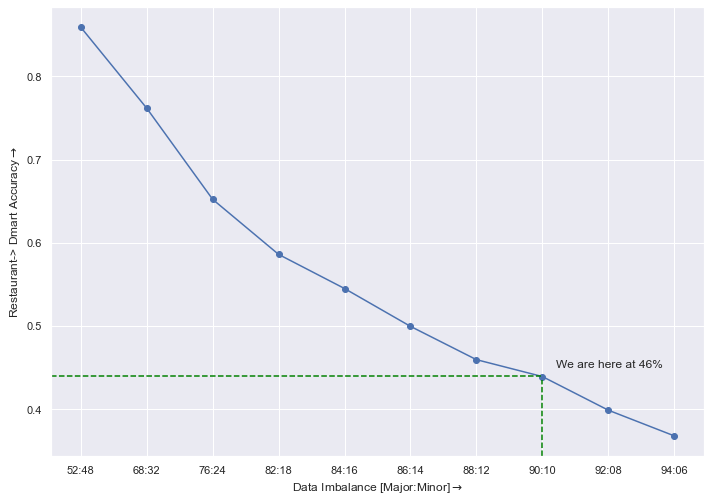

In [251]:
plt.plot(imbalance_effect.keys(),imbalance_effect.values(),marker='o');
plt.xticks(list(imbalance_effect.keys()), labels, rotation='horizontal');

plt.xlabel(f"Data Imbalance [Major:Minor]"+ r"$\rightarrow$")
plt.ylabel("Restaurant-> Dmart Accuracy" r"$\rightarrow$")
plt.axvline(x=0.08,ls='--',color='green',ymax=0.17)
plt.axhline(y=0.44,ls='--',color='green',xmax=0.75)
plt.text(x=0.082,y=0.45,s='We are here at 46%')
# plt.xlabel(r'$\rho/\rho_{ref}\;\rightarrow$', color='black')

In [74]:
def get_ci_interval(model_metrics):
    ci = 1.96 * np.std(list(model_metrics.values()))/np.sqrt(len(model_metrics))
    mean = np.mean(list(model_metrics.values()))
    return [mean-ci,mean+ci]

In [75]:
get_ci_interval(model_metrics_sweden)

[0.4725817568458729, 0.47651157648746045]

In [76]:
from sklearn.metrics import confusion_matrix

tn,fp,fn,tp = confusion_matrix(y_valid,np.where(y_pred>0.5,1,0)).ravel()
tn,fp,fn,tp

(17978, 476, 1304, 1157)

In [77]:
tp/(tp + fp)

0.7085119412124924

In [78]:
tp/(tp + fn)

0.47013409183258836

In [79]:
tn /(tn + fp)

0.9742061341714533

In [80]:
tn/(tn+fn)

0.9323721605642569

In [81]:
tp/(tp + fp)

0.7085119412124924

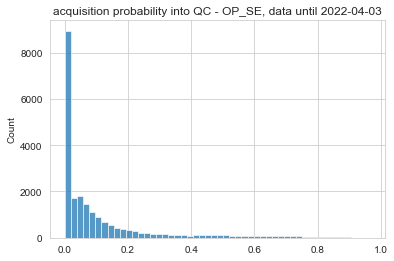

In [204]:
if IS_NOTEBOOK:
    plt.title(f'acquisition probability into QC - {GLOBAL_ENTITY_ID}, data until {DATE_UNTIL}')
    sns.histplot(pd.Series(y_pred), bins=50);

In [37]:
feat_imp = f.features.feat_importances_from_models([model_lgb], features_all)
feat_imp['feature'] = feat_imp['feature'].apply(lambda s: s.replace('ft_', '').split('__fillna_')[0])

if IS_NOTEBOOK:
    display(feat_imp
            .loc[#feat_imp['feature'].str.contains('device')
                 :
                 , ['feature', 'imp_mean']]
            #.query('imp_mean > 0.02')
            .head(30)
            .style.bar(color='#93a2be')
           )

,feature,imp_mean
1,days_since_last_order_vert_rs,0.090387
2,dist_nearest_localstore_vert_ls,0.055934
3,visit_count_l12w,0.039558
4,days_since_first_order_vert_rs,0.037856
5,delivery_fee_avg_lifetime_vert_rs,0.034453
6,deliv_dist_m_avg_lifetime_vert_rs,0.028924
7,visit_session_dur_sum_l04w,0.028499
8,deliv_time_promised_avg_lifetime_vert_rs,0.027860
9,visit_count_l04w_vs_l12w,0.027860
10,first_order_delivery_time_promised_vert_rs,0.026584


### shapley values

In [61]:
# takes around 30s
sample_size = 500
print(f'creating TreeExplainer')
explainer = shap.TreeExplainer(
    model=model_lgb,
    data=x_valid[:sample_size], # will run a lot slower when passing data
    #data=x_valid_target.loc[x_valid_target['pred']>0.99, features_all],
    #feature_perturbation='interventional',
    model_output='probability',
    #model_output='raw_value'
)

shap_values = explainer.shap_values(X=x_valid[:sample_size], y=None)

shap_values_1 = explainer(x_valid[:sample_size])

shap_values_df = pd.DataFrame(shap_values, columns=features_all)

creating TreeExplainer


ERROR plotting shap values


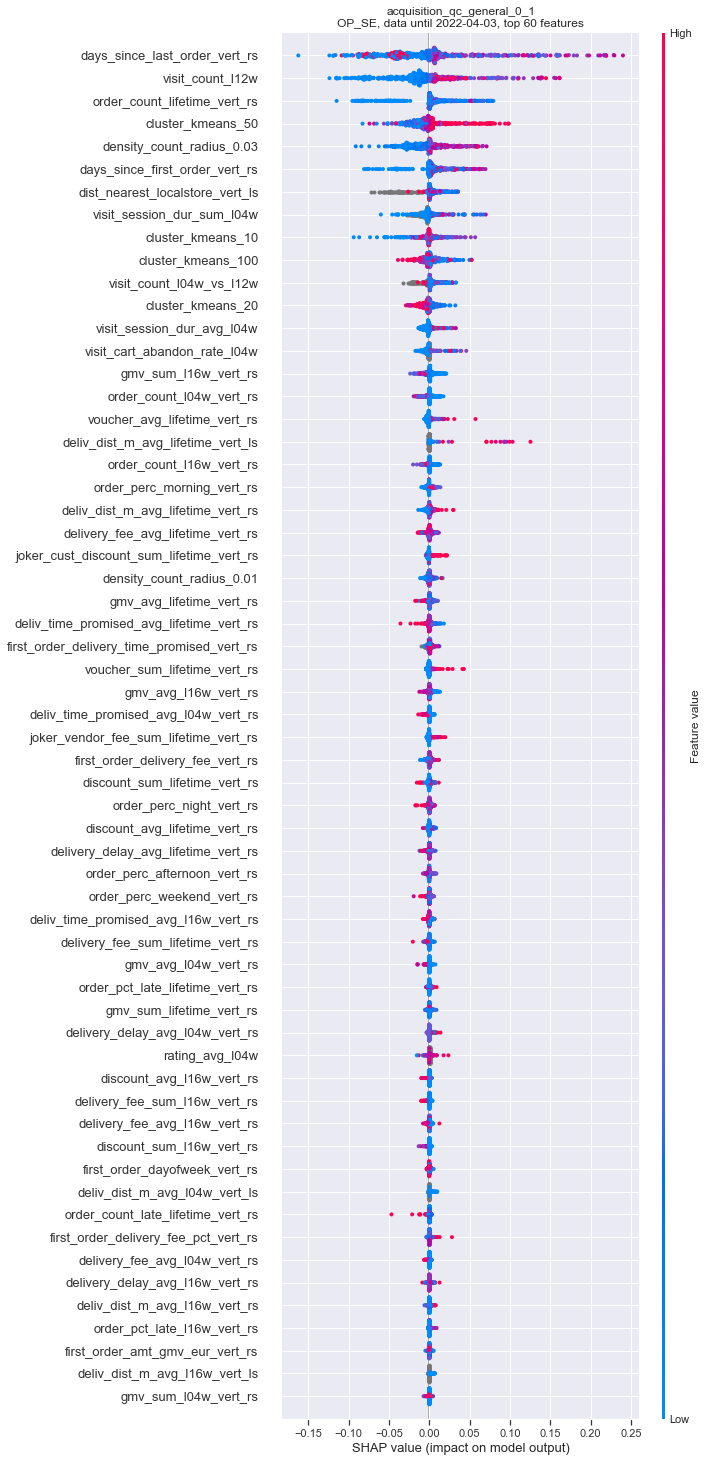

In [62]:
try:    shap_summary_plot(shap_values, x_valid[:sample_size], 60, target)
except: print('ERROR plotting shap values')

In [ ]:
# for feat in feat_imp['feature'].head(10):
#     shap.plots.scatter(shap_values_1[:,feat])


### overfit check

In [ ]:
x_valid_target = x_valid.copy()
x_valid_target['target'] = y_valid
x_valid_target['pred']   = y_pred

In [ ]:
x_valid_target['pred'].hist(bins=50);

In [ ]:
y_valid.sum()

In [ ]:
# overfit = x_valid_target.loc[
#     x_valid_target['pred']>0.999
#     ,['pred', 'target', 'days_since_first_order_vert_rs', 'gmv_sum_l04w_vert_rs', 
#       'order_count_l04w_vert_rs', 'order_count_l16w_vert_rs', 'rating_avg_l04w',
#       'dist_nearest_dmart', 
#      ]
# ]

# normal = x_valid_target.loc[
#     (x_valid_target['pred']>0.2) & (x_valid_target['pred']<0.21)
#     ,['pred', 'target', 'days_since_first_order_vert_rs', 'gmv_sum_l04w_vert_rs',
#       'order_count_l04w_vert_rs', 'order_count_l16w_vert_rs', 'rating_avg_l04w',
#       'dist_nearest_dmart', 
#      ]
# ]
# print(overfit.shape, normal.shape)

In [ ]:
# overfit.sample(25)

In [ ]:
#normal.head(5)

### permutation importance
currently requires no missing values, see [PR](https://github.com/eli5-org/eli5/pull/5)

In [ ]:
if RUN_PERMUATION_IMP:
    # takes a few minutes, doesn't work with NaN, unfortunately
    print('permutation importance: calculating...')
    perm_imp = f.features.permutation_importance(model_lgb, x_valid[:100_000].fillna(-1), y_valid[:100_000], n_iter=1)

    feature_selection = list(perm_imp.query('perm_imp>0')['feature'].values)
    # features_relevant
    print(f'features: {len(features_relevant)}/{len(features_all)}')
    
    perm_imp.style.background_gradient()
else:
    print('permutation importance: deactivated')
    feature_selection = features_all

### out of fold predictions

#### Logistic Regression
has some bugs with the solver currently

In [ ]:
# params_init = {
#     'random_state':42
# }

# model = linear_model.LogisticRegression(**params_init)

# y_pred_classes = model_selection.cross_val_predict(
#     estimator=model, 
#     method='predict_proba',
#     X=df[features_relevant].fillna(-1), # works best with -1, need to find a better imputation
#     y=df[target], 
#     cv=8, n_jobs=4, verbose=1)

In [ ]:
# y_pred_1 = y_pred_classes[:,1]
# df['preds_oof_acquisition_qc__0_1__logreg'] = y_pred_1

# print(f.metrics.binary_metrics_text(df[target], df['preds_oof_acquisition_qc__0_1__logreg']))

In [ ]:
# params_init = {
#     'random_state':42
# }

# df, models = sl.learn.predict_out_of_fold_sklearn(
#     df.fillna(-1), train_index=df.index, 
#     predict_index=None, # complete oof-predictions, no pred-only data
#     target='target_acquisition_qc__0_1', 
#     features=features_relevant,
#     n_splits=5,
#     preds_oof_col_suffix='acquisition_qc__0_1__logreg', 
#     est=linear_model.LogisticRegression,
#     predict_method='predict_proba',
#     model_init_params=params_init
# )

#### LightGBM

Create out of fold predictions with custom functions.
Uses less memory and returns the used models for further usage.

In [ ]:
print('generating predictions for trial probability...')
params_init = {
    'objective':'binary',  'learning_rate': 0.10, 'n_estimators': 2000, 'min_split_gain': 0.005,
    'num_leaves': 2**7-1, 'max_depth': 7, 'min_child_samples': 200, 'colsample_bytree': 0.8, 
    'reg_alpha': 0.5, 'reg_lambda': 0.5,
    'n_jobs': N_CORES_ASSIGNED, 'random_state': 42, 
    'verbose': -1, #'force_col_wise':True
}

df, models = f.models.predict_out_of_fold_sklearn(
    df, train_index=df.index, 
    predict_index=None, # complete oof-predictions, no pred-only data
    target=target, 
    features=feature_selection,
    n_splits=5,
    preds_oof_col_suffix='acquisition_qc_general_0_1_lgb', 
    est=lightgbm.LGBMClassifier, predict_method='predict_proba',
    model_init_params=params_init,
    model_fit_params={'verbose':50})

In [ ]:
print(f.metrics.binary_metrics_text(df[target], df['preds_oof_acquisition_qc_general_0_1_lgb']))
metrics_acq_gen = pd.DataFrame(data=f.metrics.binary_metrics(df[target], df['preds_oof_acquisition_qc_general_0_1_lgb']), index=[0])
display(metrics_acq_gen)

# pd.crosstab(index=  df['target_acquisition_qc_general_0_1'],
#             columns=df['preds_oof_acquisition_qc_general_0_1_lgb'].apply(round),
#                          values='analytical_customer_id', aggfunc='count')

In [ ]:
feat_imp = f.features.feat_importances_from_models(models, feature_selection)
feat_imp['feature'] = feat_imp['feature'].apply(lambda s: s.replace('ft_', '').split('__fillna_')[0])

utils.df_to_gs(feat_imp, bucket_gs, f'{DIR_TOPIC}feat_imp/entity={GLOBAL_ENTITY_ID}/target={target}/date={DATE_UNTIL}/feat_imp.parquet', verbose=False)

if IS_NOTEBOOK:
    display(feat_imp
            .loc[:, ['feature', 'imp_mean']]
            #.query('imp_mean > 0.02')
            .head(10)
            .style.bar(color='#93a2be')
           )

In [ ]:
if IS_NOTEBOOK:
    plt.title(f'acquisition probability into QC - {GLOBAL_ENTITY_ID}, data until {DATE_UNTIL}')
    sns.histplot(df['preds_oof_acquisition_qc_general_0_1_lgb'], bins=50);

### final

In [ ]:
# combine predictions from multiple models.. add other predictions if more models are used

#df['preds_oof_acquisition_qc__0_1__final'] = ( df['preds_oof_acquisition_qc__0_1__lgb'] * 0.9
#                                              +df['preds_oof_acquisition_qc__0_1__logreg'] * 0.1)
df['preds_'+'acquisition_qc_general_0_1'+'_final'] = ( df['preds_oof_acquisition_qc_general_0_1_lgb']#*0.5
                                                      #+df['preds_oof_acquisition_qc_0_1_lgb']*0.5
                                                     )

#print('LogReg:    ', f.metrics.binary_metrics_text(df[target], df['preds_oof_acquisition_qc__0_1__logreg']))
print('LightGBM 1:', f.metrics.binary_metrics_text(df[target], df['preds_oof_acquisition_qc_general_0_1_lgb']))
#print('LightGBM 2:', f.metrics.binary_metrics_text(df[target], df['preds_oof_acquisition_qc_0_1_lgb2']))
#print('combined:  ', f.metrics.binary_metrics_text(df[target], df['preds_'+'acquisition_qc_general_0_1'+'_final']))

### plots

In [ ]:
if IS_NOTEBOOK:
    plt.title(f'distribution actual vs predicted: {GLOBAL_ENTITY_ID}, data until {DATE_UNTIL}')
    sns.histplot(df, x='preds_oof_acquisition_qc_general_0_1_lgb', bins=50, hue=target, kde=False);

In [ ]:
# sns.histplot(df.sample(10000), x='order_hour_avg_l16w_vert_rs', bins=24*2, 
#              hue='target_acquisition_qc_general_0_1', kde=False);

## organic acquisition

In [86]:
print('='*12, 'organic vs paid trial', '='*12)
df, target = f.targets.create_acquisition_organic(df)

utils.display_value_counts(df[target])

============ organic vs paid trial ============


,target_acquisition_qc_organic_0_1,count,%
0,NaN,1019640,76.57
1,1.0,311984,23.43
2,0.0,65,0.00


In [87]:
index_train = df.loc[df[target].notnull(), :].index
index_pred  = df.loc[df[target].isnull(),  :].index
print(f'train: {len(index_train):,} pred: {len(index_pred):,}')

train: 312,049 pred: 1,019,640


### benchmark model

In [ ]:
# generate simplest possible 'predictions' as a baseline
avg = df.loc[df['order_count_lifetime_vert_qc']>0, target].mean()
df['preds_acquisition_qc_organic_0_1_benchmark'] = avg

print('benchmark model:', f.metrics.binary_metrics_text(
    df.loc[df['order_count_lifetime_vert_qc']>0, target],
    df.loc[df['order_count_lifetime_vert_qc']>0, 'preds_acquisition_qc_organic_0_1_benchmark']))

### single train/valid model

In [91]:
# split with simple 80-20 method
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    df.loc[index_train, features_all],
    df.loc[index_train, target],
    stratify=df.loc[index_train, target],
    test_size=0.2, random_state=42)

print(f'x train: {utils.df_shape(x_train).rjust(16)} | y_train:', f'{len(y_train):>9,} | mean {y_train.mean():,.6f}')
print(f'x valid: {utils.df_shape(x_valid).rjust(16)} | y_valid:', f'{len(y_valid):>9,} | mean {y_valid.mean():,.6f}')

NameError: name 'index_train' is not defined

In [ ]:
# basic parameters, not too deep, some regularization with min_child_samples and 80% feature use
params_init = {
    'objective':'binary',  'learning_rate': 0.05, 'n_estimators': 2000,
    'num_leaves': 2**7-1, 'max_depth': 7, 'min_child_samples': 100, 'colsample_bytree': 0.8, 
    'reg_alpha': 0.5, 'reg_lambda': 0.5,
    'n_jobs': N_CORES_ASSIGNED, 'random_state': 42, 'verbose': -1
}
model_lgb = lightgbm.LGBMClassifier(**params_init)

model_lgb.fit(X=x_train, y=y_train,
              eval_set=(x_valid, y_valid),
              early_stopping_rounds=20, verbose=False);

y_pred = model_lgb.predict_proba(x_valid)[:,1]
y_pred_01 = np.round(y_pred, 0)

print('LightGBM model: ', f.metrics.binary_metrics_text(y_valid, y_pred))
print('benchmark model:', f.metrics.binary_metrics_text(
    df.loc[df['order_count_lifetime_vert_qc']>0, target],
    df.loc[df['order_count_lifetime_vert_qc']>0, 'preds_acquisition_qc_organic_0_1_benchmark']))

### shapley values

In [ ]:
sample_size = 500
print(f'creating TreeExplainers')
explainer = shap.TreeExplainer(
    model=model_lgb,
    data=x_valid[:sample_size], # will run a lot slower when passing data
    #feature_perturbation='interventional',
    model_output='probability',
    #model_output='raw_value'
)

shap_values = explainer.shap_values(X=x_valid[:sample_size], y=None)

try: shap_summary_plot(shap_values, x_valid[:sample_size], 20, target)
except: print('ERROR plotting shap values')

### out of fold

Create out of fold predictions with custom functions.
Uses less memory and returns the used models for further usage.

In [ ]:
print('generating out-of-fold predictions for organic vs paid probability...')
params_init = {
    'objective':'binary',  'learning_rate': 0.05, 'n_estimators': 1000,
    'num_leaves': 2**7-1, 'max_depth': 7, 'min_child_samples': 100, 'colsample_bytree': 0.8, 
    'reg_alpha': 0.5, 'reg_lambda': 0.5,
    'n_jobs': N_CORES_ASSIGNED, 'random_state': 42, 'verbose': -1
}

# train on 5-split actual data, predict on out-of-fold actual data + open customers
df, models = f.models.predict_out_of_fold_sklearn(
    df,
    train_index=index_train, 
    predict_index=index_pred,
    target=target, 
    features=features_all,
    n_splits=5,
    preds_oof_col_suffix='acquisition_qc_organic_0_1_lgb', 
    est=lightgbm.LGBMClassifier, predict_method='predict_proba',
    model_init_params=params_init,
    model_fit_params={'verbose':50})

In [ ]:
metrics_acq_org = pd.DataFrame(data=f.metrics.binary_metrics(df.loc[index_train, target],
                                                             df.loc[index_train, 'preds_oof_acquisition_qc_organic_0_1_lgb']), index=[0])
display(metrics_acq_org)
display(pd.crosstab(index=  df.loc[index_train, 'target_acquisition_qc_organic_0_1'],
                    columns=df.loc[index_train, 'preds_oof_acquisition_qc_organic_0_1_lgb'].apply(round),
                    values='analytical_customer_id', aggfunc='count'))

In [ ]:
if IS_NOTEBOOK: sns.histplot(df, x='preds_oof_acquisition_qc_organic_0_1_lgb', bins=100, 
                             #hue=target,
                             kde=False);

In [ ]:
feat_imp = f.features.feat_importances_from_models(models, features_all)
feat_imp['feature'] = feat_imp['feature'].apply(lambda s: s.replace('ft_', '').split('__fillna_')[0])

utils.df_to_gs(feat_imp, bucket_gs, f'{DIR_TOPIC}feat_imp/entity={GLOBAL_ENTITY_ID}/target={target}/date={DATE_UNTIL}/feat_imp.parquet', verbose=False)

if IS_NOTEBOOK: 
    display(feat_imp
            .loc[:, ['feature', 'imp_mean']]
            #.query('imp_mean > 0.02')
            .head(10)
            .style.bar(color='#93a2be')
           )

In [ ]:
# final prediction, add other models (ensemble) in the future
df['preds_'+'acquisition_qc_organic_0_1'+'_final'] = (df['preds_oof_acquisition_qc_organic_0_1_lgb']
                                                      #+df['preds_oof_acquisition_qc_organic_0_1_logreg']
                                                     )#/2
print('rows with missing predictions:', df['preds_'+'acquisition_qc_organic_0_1'+'_final'].isnull().sum())

## order frequency
Predict monthly order frequency after acquisition

In [ ]:
print('='*12, 'order frequency', '='*12)
df, target = f.targets.create_acquisition_order_freq_4w_qc(df)

print('\ndistribution of actual frequencies:', end='')
display(df[target].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

In [ ]:
# Create train and prediction index. Train on QC customers, active >=7d. Predict on non-active customers.
index_train = df.loc[ (df['order_count_lifetime_vert_qc']> 1)
                     &(df['first_order_date_vert_qc']<pd.Timestamp(DATE_UNTIL_MINUS_28))
                     &(df[target].notnull()),  :].index

index_pred  = df.loc[(df['order_count_lifetime_vert_qc']<=1),  :].index

print(f'train: {len(index_train):,} | predict: {len(index_pred):,}')
print('missing targets:', df.loc[index_train, target].isnull().sum())

In [ ]:
p99 = df[target].quantile(0.99)
if IS_NOTEBOOK: 
    plt.title(f'{target}, {GLOBAL_ENTITY_ID}, data until {DATE_UNTIL}')
    df.loc[index_train, target].clip(0, p99).hist(bins=int(p99));

### benchmark model

In [ ]:
# generate simplest possible 'predictions' as a baseline
avg = df.loc[df[target].notnull(), target].mean()
df['preds_order_freq_4w_vert_qc_benchmark'] = avg

print('benchmark model:', f.metrics.regression_metrics_text(
    df.loc[df[target].notnull(), target],
    df.loc[df[target].notnull(), 'preds_order_freq_4w_vert_qc_benchmark']))

### single train/valid model

In [ ]:
# if IS_NOTEBOOK:
#     display(df.loc[#index_train
#         df[target]==3.5
#         , ['first_order_date_vert_qc', 
#            'order_count_lifetime_vert_qc', 'order_freq_4w_vert_qc']].sample(10))                     

In [ ]:
# split with simple 80-20 method
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    df.loc[index_train, features_all],
    df.loc[index_train, target],
    test_size=0.2, random_state=42)

print(f'x train: {utils.df_shape(x_train).rjust(16)} | y_train:', f'{len(y_train):>9,} | mean {y_train.mean():,.6f}')
print(f'x valid: {utils.df_shape(x_valid).rjust(16)} | y_valid:', f'{len(y_valid):>9,} | mean {y_valid.mean():,.6f}')

In [ ]:
# basic parameters, not too deep, some regularization with min_child_samples and 80% feature use
params_init = {
    'learning_rate': 0.02, 'n_estimators': 2000,
    'num_leaves': 2**7-1, 'max_depth': 7, 'min_child_samples': 100, 'colsample_bytree': 0.8, 
    'reg_alpha': 0.5, 'reg_lambda': 0.5,
    'n_jobs': N_CORES_ASSIGNED, 'random_state': 42, 
    'verbose': -1
}
model_lgb = lightgbm.LGBMRegressor(**params_init)

model_lgb.fit(X=x_train, y=y_train,
              eval_set=(x_valid, y_valid),
              early_stopping_rounds=20, verbose=50);

y_pred = model_lgb.predict(x_valid).clip(0.01, None)
best_iter = model_lgb.best_iteration_

print('LightGBM model: ', f.metrics.regression_metrics_text(y_valid, y_pred))
print('benchmark model:', f.metrics.regression_metrics_text(
    df.loc[df[target].notnull(), target],
    df.loc[df[target].notnull(), 'preds_order_freq_4w_vert_qc_benchmark']))

metrics_freq = pd.DataFrame(data=f.metrics.regression_metrics(y_valid, y_pred), index=[0])
#display(metrics_freq)

In [ ]:
feat_imp = f.features.feat_importances_from_models([model_lgb], features_all)
feat_imp['feature'] = feat_imp['feature'].apply(lambda s: s.replace('ft_', '').split('__fillna_')[0])

utils.df_to_gs(feat_imp, bucket_gs, f'{DIR_TOPIC}feat_imp/entity={GLOBAL_ENTITY_ID}/target={target}/date={DATE_UNTIL}/feat_imp.parquet', verbose=False)

if IS_NOTEBOOK:
    display(feat_imp
            .loc[:, ['feature', 'imp_mean']]
            #.query('imp_mean > 0.02')
            .head(10)
            .style.bar(color='#93a2be')
           )

### shapley values

In [ ]:
sample_size = 500
print(f'creating TreeExplainer')
explainer = shap.TreeExplainer(
    model=model_lgb,
    data=x_valid[:sample_size], # will run a lot slower when passing data
    #feature_perturbation='interventional',
    #model_output='predict_proba',
    #model_output='raw_value'
)

shap_values = explainer.shap_values(X=x_valid[:sample_size], y=None,
                                    check_additivity=False # creates errors otherwise
                                   )

In [ ]:
try: shap_summary_plot(shap_values, x_valid[:sample_size], 20, target)
except: print('ERROR plotting shap values')

### on non-acquired customers

In [ ]:
# basic parameters, same iterations as previous model
print(f'training on {len(index_train):,} acquired and predicting on {len(index_pred):,} non-acquired customers')
params_init = {
    'learning_rate': 0.02, 'n_estimators': best_iter+10,
    'num_leaves': 2**7-1, 'max_depth': 7, 'min_child_samples': 100, 'colsample_bytree': 0.8, 
    'reg_alpha': 0.5, 'reg_lambda': 0.5,
    'n_jobs': N_CORES_ASSIGNED, 'random_state': 42, 
    'verbose': -1
}
model_lgb = lightgbm.LGBMRegressor(**params_init)

model_lgb.fit(X=df.loc[index_train, features_all],
              y=df.loc[index_train, target],
              verbose=50);

y_pred = model_lgb.predict(df.loc[index_pred, features_all])

In [ ]:
if IS_NOTEBOOK:
    p99 = pd.Series(y_pred).quantile(0.99)
    pd.Series(y_pred).clip(0,p99).hist(bins=100);

In [ ]:
df.loc[index_pred, 'preds_'+'order_freq_4w_vert_qc'] = y_pred

# insert additional logic (ensembles) later
df['preds_'+'order_freq_4w_vert_qc'+'_final'] = df['preds_'+'order_freq_4w_vert_qc']

## order value - check 0 values
Predict average order value after acquisition

In [ ]:
print('='*12, 'average order value', '='*12)

if df.loc[df['order_count_lifetime_vert_qc']>0,
          'gmv_avg_lifetime_vert_qc'].isnull().sum():
    raise Exception('missing GMV AVG on vert QC')

df, target = f.targets.create_acquisition_gmv_avg_qc(df)

print('\ndistribution of actual frequencies:', end='')
display(df[target].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

In [ ]:
index_train = df.loc[ (df['order_count_lifetime_vert_qc']> 1)
                     &(df['first_order_date_vert_qc']<pd.Timestamp(DATE_UNTIL_MINUS_28))
                     &(df[target].notnull()),  :].index

index_pred  = df.loc[(df['order_count_lifetime_vert_qc']<=1),  :].index

print(f'train: {len(index_train):,} | predict: {len(index_pred):,}')
print('missing targets:', df.loc[index_train, target].isnull().sum())

In [ ]:
p99 = df[target].quantile(0.99)
if IS_NOTEBOOK: df.loc[index_train, target].clip(0, p99).hist(bins=int(p99)*2);

### benchmark model

In [ ]:
# generate simplest possible 'predictions' as a baseline
avg = df.loc[df[target].notnull(), target].mean()
df['preds_gmv_avg_lifetime_vert_qc_benchmark'] = avg

print('benchmark model:', f.metrics.regression_metrics_text(
    df.loc[df[target].notnull(), target],
    df.loc[df[target].notnull(), 'preds_gmv_avg_lifetime_vert_qc_benchmark']))

### single train/valid model

In [ ]:
# split with simple 80-20 method
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    df.loc[index_train, features_all],
    df.loc[index_train, target],
    test_size=0.2, random_state=42)

print(f'x train: {utils.df_shape(x_train).rjust(16)} | y_train:', f'{len(y_train):>9,} | mean {y_train.mean():,.6f}')
print(f'x valid: {utils.df_shape(x_valid).rjust(16)} | y_valid:', f'{len(y_valid):>9,} | mean {y_valid.mean():,.6f}')

In [ ]:
# basic parameters, not too deep, some regularization with min_child_samples and 80% feature use
params_init = {
    'learning_rate': 0.02, 'n_estimators': 2000,
    'num_leaves': 2**7-1, 'max_depth': 7, 'min_child_samples': 100, 'colsample_bytree': 0.8, 
    'reg_alpha': 0.5, 'reg_lambda': 0.5,
    'n_jobs': N_CORES_ASSIGNED, 'random_state': 42, 
    'verbose': -100
}
model_lgb = lightgbm.LGBMRegressor(**params_init)

model_lgb.fit(X=x_train, y=y_train,
              eval_set=(x_valid, y_valid),
              early_stopping_rounds=20, verbose=50);

y_pred = model_lgb.predict(x_valid)
best_iter = model_lgb.best_iteration_

print('best iteration:', best_iter)
print('LightGBM model: ', f.metrics.regression_metrics_text(y_valid, y_pred))
print('benchmark model:', f.metrics.regression_metrics_text(
    df.loc[df[target].notnull(), target],
    df.loc[df[target].notnull(), 'preds_gmv_avg_lifetime_vert_qc_benchmark']))

metrics_aov = pd.DataFrame(data=f.metrics.regression_metrics(y_valid, y_pred), index=[0])
#display(metrics_aov)

In [ ]:
# LightGBM model:  mse: 83.3652	rmse: 9.1305	mae: 4.8708	r2: 0.1230	y_pred_<=0: 0.0000	y_pred_max: 53.8100	std: 3.4669	2021-05-24 18:02:26
# LightGBM model:  mse: 81.8974	rmse: 9.0497	mae: 4.7790	r2: 0.1384	y_pred_<=0: 0.0000	y_pred_max: 47.2400	std: 3.5837	2021-05-24 19:50:59

In [ ]:
feat_imp = f.features.feat_importances_from_models([model_lgb], features_all)
feat_imp['feature'] = feat_imp['feature'].apply(lambda s: s.replace('ft_', '').split('__fillna_')[0])

utils.df_to_gs(feat_imp, bucket_gs, f'{DIR_TOPIC}feat_imp/entity={GLOBAL_ENTITY_ID}/target={target}/date={DATE_UNTIL}/feat_imp.parquet', verbose=False)

if IS_NOTEBOOK:
    display(feat_imp
            .loc[:, ['feature', 'imp_mean']]
            #.query('imp_mean > 0.02')
            .head(10)
            .style.bar(color='#93a2be')
           )

### shapley values

In [ ]:
sample_size = 500
print(f'creating TreeExplainer')
explainer = shap.TreeExplainer(
    model=model_lgb,
    data=x_valid[:sample_size], # will run a lot slower when passing data
    #feature_perturbation='interventional',
    #model_output='predict_proba',
    #model_output='raw_value',
    check_additivity=False
)

In [ ]:
# there are some weird behaviours.. check if this works, then continue with the next one as well
works = False
try:
    shap_values = explainer.shap_values(X=x_valid[:sample_size], y=None)
    works = True
except Exception as e:
    print(e)
#shap_values_1 = explainer(x_valid[:sample_size])

In [ ]:
if works:
    try:
        shap_summary_plot(shap_values, x_valid[:sample_size], 20, target)
    except:
        print('ERROR plotting shap values')
else:
    print('cant')

In [ ]:
# for feat in feat_imp['feature'].head(10):
#     shap.plots.scatter(shap_values_1[:,feat])

### on non-acquired customers

In [ ]:
# basic parameters, same iterations as previous model
print(f'training on {len(index_train):,} acquired and predicting on {len(index_pred):,} non-acquired customers')
params_init = {
    'learning_rate': 0.02, 'n_estimators': best_iter+10,
    'num_leaves': 2**7-1, 'max_depth': 7, 'min_child_samples': 100, 'colsample_bytree': 0.8, 
    'reg_alpha': 0.5, 'reg_lambda': 0.5,
    'n_jobs': N_CORES_ASSIGNED, 'random_state': 42, 
    'verbose': -1
}
model_lgb = lightgbm.LGBMRegressor(**params_init)

model_lgb.fit(X=df.loc[index_train, features_all],
              y=df.loc[index_train, target],
              verbose=50);

y_pred = model_lgb.predict(df.loc[index_pred, features_all])

print(f'y_pred: mean {y_pred.mean():.2f}, std {y_pred.std():.2f}, min {y_pred.min():.2f}, max {y_pred.max():.2f}')

In [ ]:
# regular predictions and percentiles
df.loc[index_pred, 'preds_'+'gmv_avg_lifetime_vert_qc'] = y_pred

# insert additional logic (ensemble) later
df['preds_'+'gmv_avg_lifetime_vert_qc'+'_final'] = df['preds_'+'gmv_avg_lifetime_vert_qc']

In [ ]:
if IS_NOTEBOOK: 
    p995 = pd.Series(y_pred).quantile(0.995)    
    pd.Series(y_pred).clip(0,p995).hist(bins=int(p995)*2);

# export

## metrics

In [ ]:
metrics_all = pd.concat(objs=[metrics_acq_gen, metrics_acq_org, metrics_freq, metrics_aov])
metrics_all.index = ['target_acquisition_qc_general_0_1', 'target_acquisition_qc_organic_0_1', 'target_order_freq_4w_vert_qc', 'target_gmv_avg_lifetime_vert_qc']
metrics_all.index.name = 'target'
metrics_all = metrics_all.reset_index()
display(metrics_all)

In [ ]:
utils.df_to_gs(metrics_all, bucket_gs, f'{DIR_TOPIC}metrics/entity={GLOBAL_ENTITY_ID}/date={DATE_UNTIL}/metrics_all_targets.parquet', verbose=False)

## table

In [ ]:
target_cols = sorted([col for col in df.columns if col.startswith('target')])
pred_cols   = sorted([col for col in df.columns if col.startswith('preds') and col.endswith('final') and col!='preds_benchmark'])
print(f'found {len(target_cols)} targets, {(len(pred_cols))} prediction columns')

if IS_NOTEBOOK: 
    print(target_cols)
    print(pred_cols)

In [ ]:
export = (df
          .loc[:, [
              'analytical_customer_id', *target_cols, *pred_cols,
           ]]
          .sort_values('analytical_customer_id') # sort for BigQuery optimization
          .reset_index(drop=True)
         )

In [ ]:
for p in ['target_acquisition_qc_organic_0_1', 'target_gmv_avg_lifetime_vert_qc', 'target_order_freq_4w_vert_qc',
          'preds_acquisition_qc_general_0_1_final', 'preds_acquisition_qc_organic_0_1_final',
          'preds_gmv_avg_lifetime_vert_qc_final', 'preds_order_freq_4w_vert_qc_final']:
    export[p] = export[p].astype('float32')

In [ ]:
if IS_NOTEBOOK: display(utils.df_info(export))

In [ ]:
# utils.df_to_gs(
#     export, bucket_gs, 
#     f'{DIR_TOPIC}predictions/entity={GLOBAL_ENTITY_ID}/date={DATE_UNTIL}/preds.parquet')

In [ ]:
gc.collect()

In [184]:
converted = df.loc[test_df.index][df['target_acquisition_qc_general_0_1']==1]
unconverted = df.loc[test_df.index][df['target_acquisition_qc_general_0_1']==0]

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


In [132]:
cols = ['days_since_first_order_vert_rs',
        'days_since_last_order_vert_rs',
        'first_order_amt_gmv_eur_vert_rs',
        'first_order_delivery_dist_m_vert_rs',
        'order_perc_weekend_vert_rs',
        'order_perc_morning_vert_rs',
        'order_perc_afternoon_vert_rs',
        'order_perc_night_vert_rs',
        'order_count_lifetime_vert_rs',
        'order_count_l04w_vert_rs',
        'order_count_l16w_vert_rs',
        'gmv_sum_lifetime_vert_rs',
        'gmv_sum_l04w_vert_rs',
        'gmv_sum_l16w_vert_rs',
        'gmv_avg_lifetime_vert_rs',
        'gmv_avg_lifetime_vert_qc',
        'gmv_avg_l04w_vert_rs',
        'gmv_avg_l16w_vert_rs',
        'deliv_dist_m_avg_l16w_vert_rs',
        'coverage_vendors_qc',
        'coverage_dmart',
        'coverage_localstore',
        'dist_nearest_vendor_qc',
        'dist_nearest_dmart',
        'visit_cart_abandon_rate_l04w',
        'target_acquisition_qc_general_0_1'
       ]

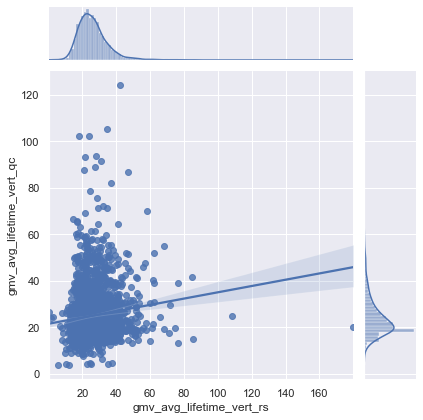

In [207]:
sns.set(rc={'figure.figsize':(27.7,22.27)})
sns.jointplot(
    data = converted[['gmv_avg_lifetime_vert_rs','gmv_avg_lifetime_vert_qc']],
    x = 'gmv_avg_lifetime_vert_rs',
    y = 'gmv_avg_lifetime_vert_qc',
    kind = 'reg'
)
# plt.xlim([0,90])

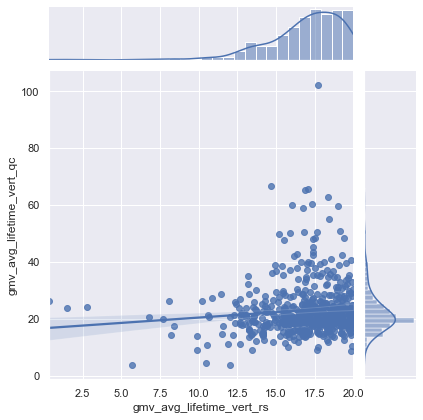

In [214]:
sns.set(rc={'figure.figsize':(27.7,22.27)})
sns.jointplot(
    data = converted[converted['gmv_avg_lifetime_vert_rs'].between(0,20)][['gmv_avg_lifetime_vert_rs','gmv_avg_lifetime_vert_qc']],
    x = 'gmv_avg_lifetime_vert_rs',
    y = 'gmv_avg_lifetime_vert_qc',
    kind = 'reg'
)

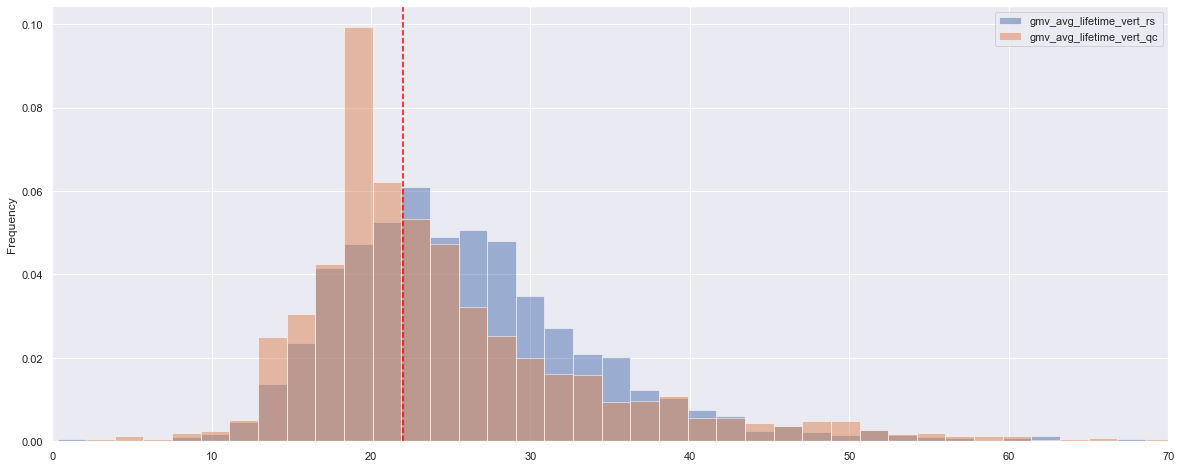

In [172]:
converted[['gmv_avg_lifetime_vert_rs','gmv_avg_lifetime_vert_qc']].plot.hist(bins=100,figsize=(20,8),alpha=0.5,density=True)

plt.xlim([0,70])
plt.axvline(22,ls='--',color='red')

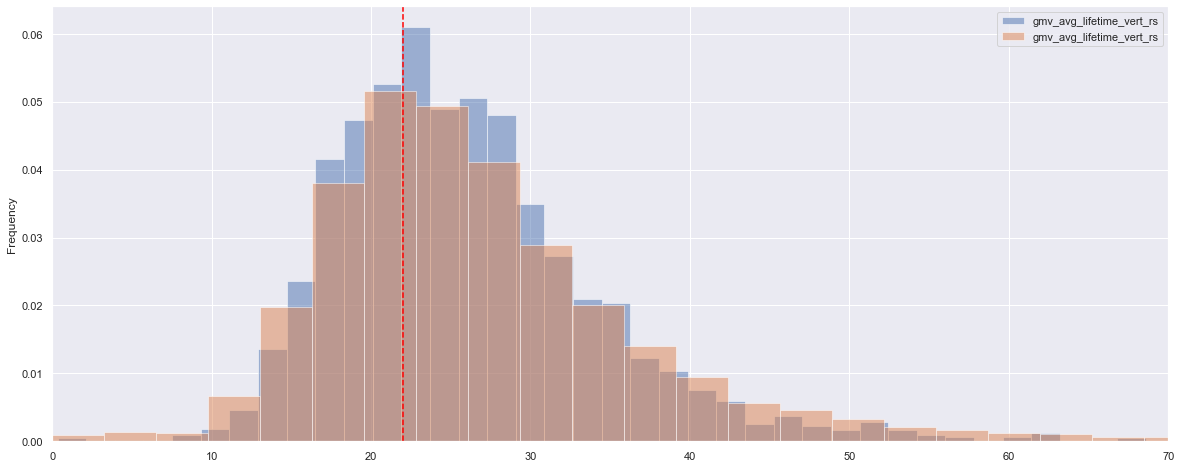

In [194]:
fig,ax = plt.subplots(1,1)
converted[['gmv_avg_lifetime_vert_rs']].plot.hist(bins=100,figsize=(20,8),alpha=0.5,density=True,ax=ax)
unconverted[['gmv_avg_lifetime_vert_rs']].plot.hist(bins=100,figsize=(20,8),alpha=0.5,density=True,ax=ax)

plt.xlim([0,70])
plt.axvline(22,ls='--',color='red')

In [ ]:
converted[['gmv_avg_lifetime_vert_rs','gmv_avg_lifetime_vert_qc']].plot.hist(bins=100,figsize=(20,8),alpha=0.5,density=True)

plt.xlim([0,70])
plt.axvline(22,ls='--',color='red')

In [ ]:
df.groupby()

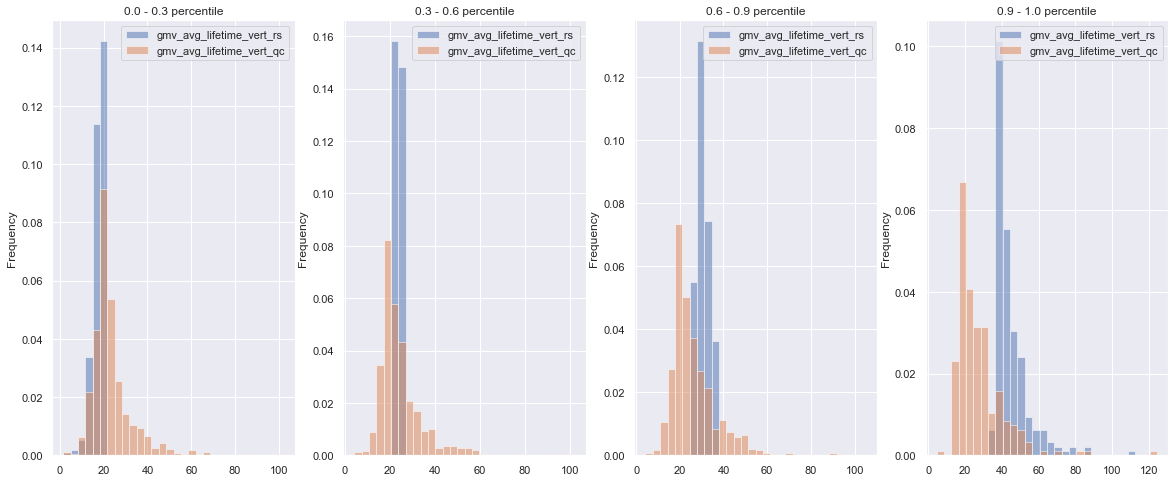

In [195]:
stepsize = 0.3
sns.set(rc={'figure.figsize':(27.7,22.27)})
perc_range = np.arange(0,1+stepsize,stepsize)
steps = len(perc_range)-1
fig,ax = plt.subplots(1,steps)
for i in range(steps):
    if perc_range[i+1] > 1.0:
        perc_range[i+1] = 1.0

    converted[
        (converted['gmv_avg_lifetime_vert_rs']>converted['gmv_avg_lifetime_vert_rs'].quantile(perc_range[i]))
        &
        (converted['gmv_avg_lifetime_vert_rs']<converted['gmv_avg_lifetime_vert_rs'].quantile(perc_range[i+1]))
    ][['gmv_avg_lifetime_vert_rs','gmv_avg_lifetime_vert_qc']].plot.hist(bins=30,figsize=(20,8),alpha=0.5,density=True,ax=ax[i])
    ax[i].set_title(f'{round(perc_range[i],2)} - {round(perc_range[i+1],2)} percentile')

In [82]:
perc_range

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [79]:
perc_range

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [120]:
test_df = x_valid.join(y_valid)

In [121]:
test_df['predict_proba'] = model_lgb.predict_proba(x_valid)[:,1]

target_acquisition_qc_general_0_1
0    AxesSubplot(0.125,0.125;0.775x0...
1    AxesSubplot(0.125,0.125;0.775x0...
Name: predict_proba, dtype: object

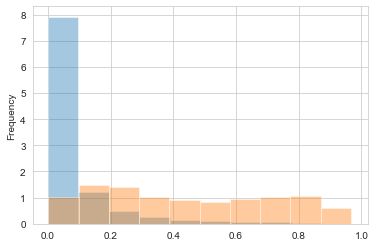

In [125]:
test_df.groupby('target_acquisition_qc_general_0_1')['predict_proba'].plot.hist(density=True,alpha = 0.4)